In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,roc_auc_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  StratifiedKFold,train_test_split,cross_val_score,cross_validate
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.pipeline import make_pipeline
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers
plt.style.use(['dark_background'])

In [3]:
tf.test.gpu_device_name() 

'/device:GPU:0'

In [4]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.shape

(284807, 31)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
not_fraud=(df['Class'].value_counts()[0]/len(df))*100
fraud=(df['Class'].value_counts()[1]/len(df))*100
print(f'Not Fraud: {not_fraud:.2f}% of dataset')
print(f'Fraud: {fraud:.2f}% of dataset')

Not Fraud: 99.83% of dataset
Fraud: 0.17% of dataset


Text(0.5, 1.0, 'Class Distributions of Frauds(1) and Not frauds(0)')

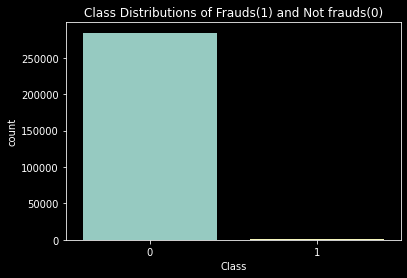

In [ ]:
sns.countplot('Class',data=df)
plt.title('Class Distributions of Frauds(1) and Not frauds(0)')

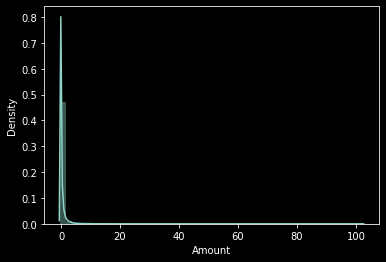

In [ ]:
sns.distplot(df['Amount'])

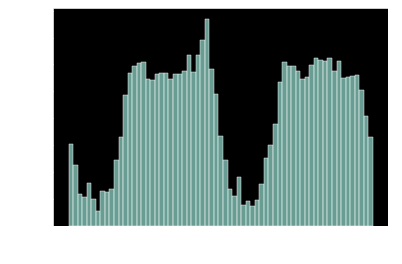

In [ ]:
sns.histplot(df['Time'])

**Scaling Amount and time features**

In [10]:
scaler=StandardScaler()
df['Time']=scaler.fit_transform(df['Time'].values.reshape(-1,1))
df['Amount']=scaler.fit_transform(df['Amount'].values.reshape(-1,1))

**Data Spliting**

In [6]:
#Randomly suffling data
df=df.sample(frac=1)

In [11]:
x=df.iloc[:,0:30].values
y=df.iloc[:, 30:].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)
y_train=np.ravel(y_train)

In [13]:
pd.DataFrame(y_train).value_counts()

0    199006
1       358
dtype: int64

In [12]:
pd.DataFrame(y_test).value_counts()

0    85309
1      134
dtype: int64

# Random OverSampling

**It is the process of randamly duplicating sample/rows of Minority classes!**


In [14]:
#sampling strategy of 0.6 means making  no of rows/sample of minoririty class 60%  of majority class
OverSampler=RandomOverSampler(sampling_strategy=0.6)
os_x_train,os_y_train=OverSampler.fit_resample(x_train,y_train)

In [15]:
pd.DataFrame(os_y_train).value_counts()

0    199006
1    119403
dtype: int64

# SMOTE(Synthetic Minority Over-sampling Technique)


**It is the process of genrating data for miniority classes!** 

In [16]:
#sampling strategy of 0.6 means making  no of rows/sample of minoririty class 60%  of majority class
smote=SMOTE(sampling_strategy=0.6)
sm_x_train,sm_y_train=smote.fit_resample(x_train,y_train)

In [17]:
pd.DataFrame(sm_y_train).value_counts()

0    199006
1    119403
dtype: int64

# Model Building

***We want model to decrease False Negatives (Predcting Fraud as not Fraud) as much as possible. But we also want to make sure there is less False Positive(predicting Not fraud as Fraud) too!***

In [18]:
def model_report(y_test,y_pred):
    print(f'----Confusion matrix---- \n \n{confusion_matrix(y_test,y_pred)}\n')
    print(f'Roc_Auc Score : {roc_auc_score(y_test,y_pred)}\n')
    print(classification_report(y_test,y_pred))

In [25]:
def cross_validation(estimator,cv=StratifiedKFold()):
  #To make sure result given by the model is just by a chance of train_test_split or not
  scores=cross_validate(estimator,x,np.ravel(y),cv=cv,scoring=['f1','recall'],n_jobs=-1)  
  f1_scores=scores['test_f1']
  recall=scores['test_recall']
  print(f'F1 Scores: {f1_scores}')
  print(f'Avg F1 Score:{f1_scores.mean()}\n')

  print(f'Recall: {recall}')
  print(f'Avg Recall Score:{recall.mean()}')

# Random Forest Classfier

**In Orginal Data**

In [23]:
rf_classfier=RandomForestClassifier(class_weight='balanced_subsample',n_jobs=-1)
rf_classfier.fit(x_train,y_train)
y_pred=rf_classfier.predict(x_test)
model_report(y_test, y_pred)

----Confusion matrix---- 
 
[[85305     4]
 [   29   105]]

Roc_Auc Score : 0.8917676005908635

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85309
           1       0.96      0.78      0.86       134

    accuracy                           1.00     85443
   macro avg       0.98      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



In [26]:
cross_validation(RandomForestClassifier())

F1 Scores: [0.84745763 0.84269663 0.89010989 0.8603352  0.84090909]
Avg F1 Score:0.8563016865763668

Recall: [0.75757576 0.75757576 0.82653061 0.78571429 0.75510204]
Avg Recall Score:0.7764996907854049


**Seems it is providing more False Negatives values since we have less recall values.Let`see if random forest with randomoversampling or SMOTE can decrease False Negatives** 

**With Random OverSampling**

In [27]:
rf_classifier_os=RandomForestClassifier()
rf_classifier_os.fit(os_x_train,os_y_train)
y_pred=rf_classifier_os.predict(x_test)
model_report(y_test, y_pred)

----Confusion matrix---- 
 
[[85305     4]
 [   27   107]]

Roc_Auc Score : 0.8992302871580276

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85309
           1       0.96      0.80      0.87       134

    accuracy                           1.00     85443
   macro avg       0.98      0.90      0.94     85443
weighted avg       1.00      1.00      1.00     85443



In [28]:
imb_pipeline=make_pipeline(RandomOverSampler(sampling_strategy=0.6),RandomForestClassifier())
cross_validation(imb_pipeline)

F1 Scores: [0.85555556 0.85714286 0.90710383 0.87431694 0.84745763]
Avg F1 Score:0.8683153609688758

Recall: [0.77777778 0.78787879 0.84693878 0.81632653 0.76530612]
Avg Recall Score:0.7988455988455989


**Random Forest with random oversampling also gave lesser Recall!**


**With SMOTE**

In [30]:
rf_classifier_sm=RandomForestClassifier()
rf_classifier_sm.fit(sm_x_train,sm_y_train)
y_pred=rf_classifier_sm.predict(x_test)
model_report(y_test, y_pred)

----Confusion matrix---- 
 
[[85301     8]
 [   23   111]]

Roc_Auc Score : 0.9141322161071

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85309
           1       0.93      0.83      0.88       134

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443



In [31]:
imb_pipeline=make_pipeline(SMOTE(sampling_strategy=0.6),RandomForestClassifier())
cross_validation(imb_pipeline)

F1 Scores: [0.84816754 0.82901554 0.89839572 0.85263158 0.84782609]
Avg F1 Score:0.8552072942274981

Recall: [0.81818182 0.80808081 0.85714286 0.82653061 0.79591837]
Avg Recall Score:0.8211708925994641


**Random Forest with SMOTE gave better Recall and Performed better than other model!**

# XGBoost Classifier¶

In [32]:
xgboost=xgb.XGBClassifier(tree_method='gpu_hist')
xgboost.fit(x_train,np.ravel(y_train))
y_pred=xgboost.predict(x_test)
model_report(y_test, y_pred)

----Confusion matrix---- 
 
[[85299    10]
 [   22   112]]

Roc_Auc Score : 0.9178518372980542

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85309
           1       0.92      0.84      0.88       134

    accuracy                           1.00     85443
   macro avg       0.96      0.92      0.94     85443
weighted avg       1.00      1.00      1.00     85443



In [34]:
cross_validation(xgb.XGBClassifier(tree_method='gpu_hist'))

F1 Scores: [0.82681564 0.81967213 0.87700535 0.84210526 0.84090909]
Avg F1 Score:0.8413014950532421

Recall: [0.74747475 0.75757576 0.83673469 0.81632653 0.75510204]
Avg Recall Score:0.7826427540713254


**XGBOOST also gave lesser Recall!**

<h1>Neural Networks</h1>

In [46]:
model=tf.keras.Sequential([
   layers.Dense(units=65,activation=tf.nn.relu,input_dim=x_train.shape[1]),
   layers.Dropout(0.2),
   layers.Dense(35,activation=tf.nn.relu),
   layers.Dense(1,activation=tf.nn.sigmoid)
  ])
optimizer=tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['Precision','Recall'])

In [47]:
history=model.fit(x_train,y_train,batch_size=128,epochs=35,validation_data=(x_test,y_test),class_weight={0:1,1:5})

Epoch 1/35
1558/1558 [==============================] - 7s 4ms/step - loss: 0.1084 - precision: 0.0634 - recall: 0.1480 - val_loss: 0.0098 - val_precision: 0.8876 - val_recall: 0.5896
Epoch 2/35
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0206 - precision: 0.8288 - recall: 0.6760 - val_loss: 0.0047 - val_precision: 0.8739 - val_recall: 0.7761
Epoch 3/35
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0149 - precision: 0.8308 - recall: 0.7682 - val_loss: 0.0043 - val_precision: 0.8425 - val_recall: 0.7985
Epoch 4/35
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0128 - precision: 0.8023 - recall: 0.7821 - val_loss: 0.0040 - val_precision: 0.8148 - val_recall: 0.8209
Epoch 5/35
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0113 - precision: 0.7906 - recall: 0.8017 - val_loss: 0.0036 - val_precision: 0.8333 - val_recall: 0.8209
Epoch 6/35
1558/1558 [==============================] - 6s 4ms/step - loss: 0.01

**Model Evaluation**

In [48]:
def compute_f1score(precision,recall):
  f1_score=(2*precision*recall)/(precision+recall)
  return f1_score

#Retriving loss,precision,recall from History
loss=history.history['loss']
val_loss=history.history['val_loss']

precision=np.array(history.history['precision'])
recall=np.array(history.history['recall'])
f1_score=compute_f1score(precision,recall)

val_precision=np.array(history.history['val_precision'])
val_recall=np.array(history.history['val_recall'])
val_f1_score=compute_f1score(val_precision,val_recall)

epochs=range(len(loss))

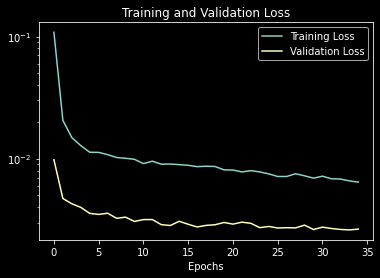

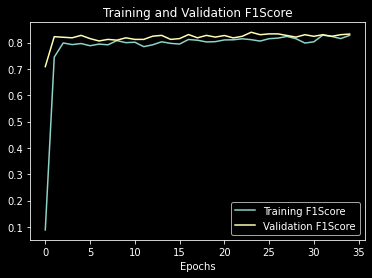

In [51]:
#ploting training and validation loss
plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.yscale('log')
plt.legend()
plt.show()

#ploting training and validation F1Score
plt.plot(epochs,f1_score,label='Training F1Score')
plt.plot(epochs,val_f1_score,label='Validation F1Score')
plt.title('Training and Validation F1Score')
plt.xlabel('Epochs')
#plt.yscale('log')
plt.legend()
plt.show()

In [50]:
y_pred=model.predict_classes(x_test)
model_report(y_test,y_pred)

----Confusion matrix---- 
 
[[85283    26]
 [   20   114]]

Roc_Auc Score : 0.9252207471241946

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85309
           1       0.81      0.85      0.83       134

    accuracy                           1.00     85443
   macro avg       0.91      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443



**Neural Network gave similar recall as Random Forests with SMOTE but gave less precision. Nerural Network didnt gave an Improvement!**<br>
***Random Forest with SMOTE Performed better than other model!***